# Análise de sentimentos

Para obter informações dos tweets coletados iremos efetuar uma anális de sentimentos no tweets, isto é, para cada um dos tweets desejamos indentificar se o texto possui um sentimento positivo ou negativo associado, e além disso, também seremos capazes de avaliar se o texto representa uma opinião ou um fato. Para a análise de sentimentos utilizaremos a biblioteca __Textblob__. No entanto, uma das limitações muitas vezes encontradas para fazer processamento de textos é que a maior parte das ferramentas dão suporte apenas para o inglês, por esse motivo, iremos traduzir cada um dos tweets para inglês utilizando a biblioteca __Googletrans__.

In [ ]:
!pip install googletrans

## Tradução e análise de sentimentos

In [2]:
import textblob
import pandas as pd
from googletrans import Translator
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import numpy as np
import altair as alt

In [ ]:
df = pd.read_csv("../data/tweets/preprocessed_tweets.csv", sep = "~").drop(columns = ["Unnamed: 0"])
trans = lambda tw : translator.translate(tw).text
full_text_en = []
for i in tqdm(range(0, 12000, 1000)):
    translator = Translator()
    for tw in df.full_text[i:i+1000]:
        full_text_en.append(trans(tw))
for tw in df.full_text[12000:]:
    full_text_en.append(trans(tw))
df["full_text_en"] = full_text_en
pol = lambda x : textblob.TextBlob(x).polarity
sub = lambda x : textblob.TextBlob(x).subjectivity
df['polarity'] = df.full_text_en.apply(pol)
df['subjectivity'] = df.full_text_en.apply(sub)

100%|██████████| 12/12 [50:16<00:00, 251.41s/it]


In [4]:
#df.to_pickle("data/tweets/sentiment_analysis.pkl")
df = pd.read_pickle('data/tweets/sentiment_analysis.pkl')

Com os dados já traduzidos, vamos observar alguns tweets em português e em inglês para verificar se as traduções são satisfatórias.

In [5]:
for i in range(5):
    print("Português:")
    print(df.full_text[i])
    print()
    print("Inglês")
    print("\t" + df.full_text_en[i])
    print()

Português:
-Edifício Joelma/SP, 1974.

-Sgt CASSANIGA salta de helicóptero da FAB no terraço do edifício em chamas para salvar vidas, em uma das maiores tragédias na história do Brasil.

. Link no YouTube: https://t.co/JW8q4qN3a8 https://t.co/3Ulw3G96D5

Inglês
	- Joelma / SP Building, 1974.

-Sgt CASSANIGA jumps from the FAB helicopter on the terrace of the burning building to save lives, in one of the greatest tragedies in the history of Brazil.

. Link on YouTube: https://t.co/JW8q4qN3a8 https://t.co/3Ulw3G96D5

Português:
- Água para quem tem sede.
- Liberdade para um povo. 
- Brasil acima de tudo, Deus acima de todos!
- BOM DIA.

. YouTube: https://t.co/eS5aHQfMXu https://t.co/UERpWo4NbR

Inglês
	- Water for those who are thirsty.
- Freedom for a people.
- Brazil above all, God above all!
- GOOD MORNING.

. YouTube: https://t.co/eS5aHQfMXu https://t.co/UERpWo4NbR

Português:
@tarcisiogdf @MInfraestrutura 🤝🇧🇷, Ministro!

Inglês
	@tarcisiogdf @MInfraestrutura 🤝🇧🇷, Minister!

Portugu

## Visualização dos resultados

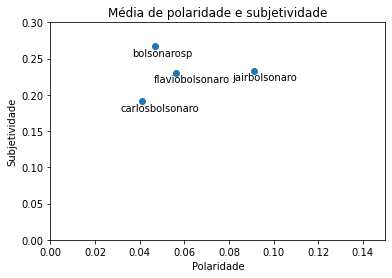

In [7]:
plot_data = df.groupby(by = "name").mean()
plt.scatter(plot_data.polarity, plot_data.subjectivity)
plt.title("Média de polaridade e subjetividade")
for row in range(len(plot_data)):
    plt.annotate(plot_data.index[row], (plot_data.polarity[row] - 0.01, plot_data.subjectivity[row] - 0.013))
plt.xlabel("Polaridade")
plt.ylabel("Subjetividade")
plt.xlim([0, 0.15])
plt.ylim([0, 0.3])
plt.savefig('images/mean_pol_subj.pdf')
plt.show()

Observamos que todos os perfis estão próximos, no entanto, temos que o perfil do vereador Carlos Bolsonaro (@carlosbolsonaro) é o menos polarizado e subjetivo entre os observados. Também temos que o perfil mais subjetivo é o do deputado Eduardo Bolsonaro (@bolsonarosp) e o mais polarizado é do presidente Jair Bolsonaro (@jairbolsonaro).

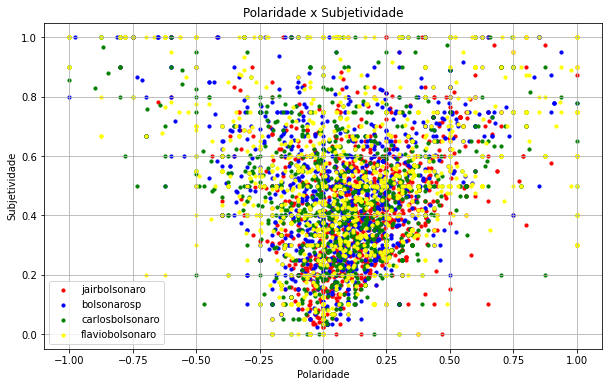

In [8]:
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
ax.set_title("Polaridade x Subjetividade")
for (name, color) in [("jairbolsonaro", "red"), ("bolsonarosp", "blue"),
             ("carlosbolsonaro", "green"), ("flaviobolsonaro", "yellow")]:
    ax.scatter(df[df.name == name].polarity, df[df.name == name].subjectivity, c = color, label = name, s = 10)
ax.set_xlabel("Polaridade")
ax.set_ylabel("Subjetividade")
plt.legend()
plt.grid()
plt.savefig('images/pol_subj_by_name.pdf')
plt.show()

Podemos trazer mais informação para essa visualização utilizando a biblioteca Altair para podermos visualizar o Tweet em cada um dos pontos, no entanto, por adequações da biblioteca, iremos utilizar apenas uma amostra de 2000 observações.

In [25]:
plot_data = df.sample(n = 2000)
chart = alt.Chart(plot_data).mark_circle(size=60).encode(
    x='polarity',
    y='subjectivity',
    color=alt.Color('name', legend=alt.Legend(title="Usuário")),
    tooltip=[alt.Tooltip('name', title = "Usuário"), alt.Tooltip('full_text', title = "Tweet")]
).interactive()
chart.save("images/pol_subj_by_name.html")
chart

alt.Chart(...)

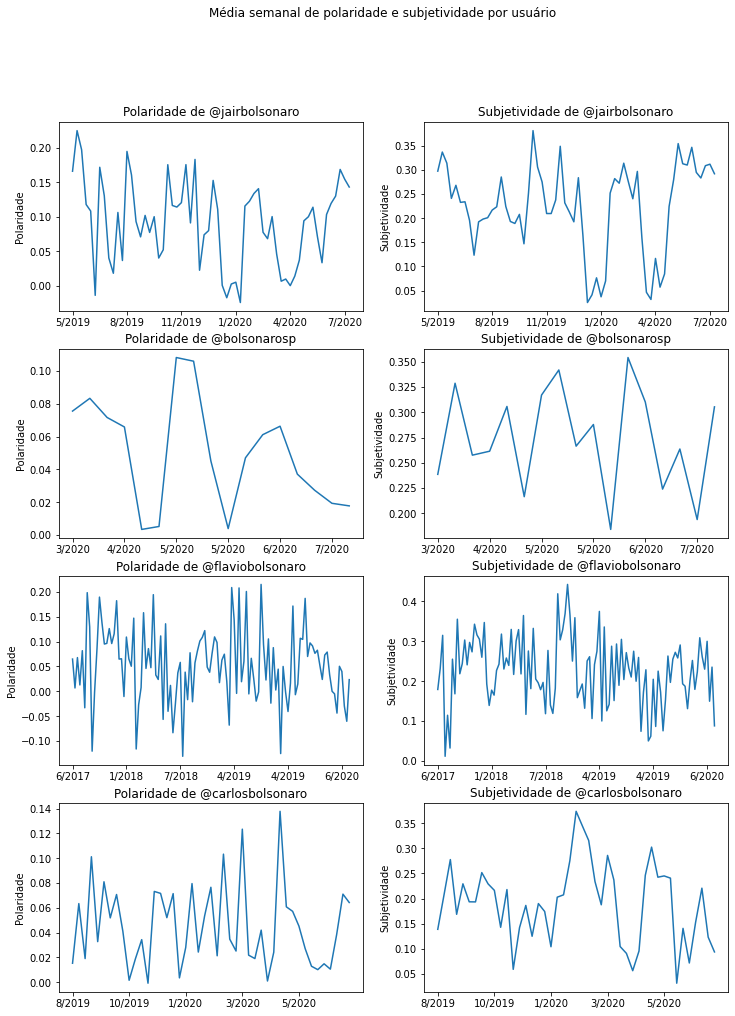

In [9]:
plot_data = df.groupby(by = ["name","year", "month", "day"]).mean()
plot_data.reset_index(inplace = True)
fig, axis = plt.subplots(nrows = 4, ncols = 2)
fig.set_figheight(16)
fig.set_figwidth(12)
plt.suptitle("Média semanal de polaridade e subjetividade por usuário")
name = ['jairbolsonaro', 'bolsonarosp', 'flaviobolsonaro', 'carlosbolsonaro']
for (i, row) in enumerate(axis):
    row_data = plot_data[plot_data.name == name[i]].rolling(7).mean().iloc[::7, :]
    row_data.dropna(inplace = True)
    date_ticks = row_data.month.map(lambda x : str(int(np.floor(x)))) + "/" + row_data.year.map(lambda x : str(int(x)))
    n_ticks = int(len(date_ticks)/5)
    row[0].set_title("Polaridade de @" + name[i])
    row[0].plot(row_data.index, row_data.polarity)
    row[0].set_ylabel("Polaridade")
    row[0].set_xticks(row_data.index[::n_ticks])
    row[0].set_xticklabels(date_ticks[::n_ticks])

    row[1].set_title("Subjetividade de @"+ name[i])
    row[1].plot(row_data.index, row_data.subjectivity)
    row[1].set_ylabel("Subjetividade")
    row[1].set_xticks(row_data.index[::n_ticks])
    row[1].set_xticklabels(date_ticks[::n_ticks])
plt.savefig("images/pol_subj_by_time.pdf")
plt.show()

Nessa ultima visualização, vemos que a polaridade e subjetividade dos tweets não apresentam nenhum comportamento padronizado ao longo do tempo. Por fim, vamos observar alguns dos tweets mais polarizados e subjetivos encontrados.

In [10]:
df = df.sort_values('polarity')
for i in [0, 1, -2, -1]:
    if i == 0:
        print("Tweets com polaridade negativa:")
    elif i == -2:
        print()
        print("Tweets com polaridade positiva:")
    print("Usuário: " + df.iloc[i, :]['name'] + " Data: " + str(df.iloc[i, :].date))
    print("Tweet:" + df.iloc[i, :].full_text)

df = df.sort_values('subjectivity', ascending = False)
print()
print("Tweets com subjetividade:")
for i in [0, 1]:
    print("Usuário: " + df.iloc[i, :]['name'] + " Data: " + str(df.iloc[i, :].date))
    print("Tweet:" + df.iloc[i, :].full_text)

Tweets com polaridade negativa:
Usuário: carlosbolsonaro Data: 2020-03-16 00:23:19+00:00
Tweet:Não adianta pagar de porta-voz da nação. O povo o odeia! Não os representa. Saia da bolha, vá na rua e perceberá!
Usuário: flaviobolsonaro Data: 2017-09-18 11:10:10+00:00
Tweet:Legalizar a pedofilia é o objetivo desses imundos! https://t.co/KMLqb4g1Da

Tweets com polaridade positiva:
Usuário: jairbolsonaro Data: 2019-06-12 22:42:37+00:00
Tweet:Feliz dia dos namorados! 👍 https://t.co/e1svTppojj
Usuário: jairbolsonaro Data: 2020-07-27 20:51:13+00:00
Tweet:-Edifício Joelma/SP, 1974.

-Sgt CASSANIGA salta de helicóptero da FAB no terraço do edifício em chamas para salvar vidas, em uma das maiores tragédias na história do Brasil.

. Link no YouTube: https://t.co/JW8q4qN3a8 https://t.co/3Ulw3G96D5

Tweets com subjetividade:
Usuário: jairbolsonaro Data: 2020-07-27 20:51:13+00:00
Tweet:-Edifício Joelma/SP, 1974.

-Sgt CASSANIGA salta de helicóptero da FAB no terraço do edifício em chamas para salvar 